In [67]:
%reset

In [68]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg, scipy.integrate
import do
from importlib import reload

from quantum_systems import ODQD, GeneralOrbitalSystem

In [69]:
### PARAMETERS ###
l = 10 # Number of eigenstates of the HO potential --> we use these functions to generate the single particle WF
grid_length = 10  # The width of the one-dimensional grid
num_grid_points = 201  # The number of discretized points on the grid.
# More points give better results for the single-particle basis at the cost of slower setup.
alpha = 1  # The strength of the Coulomb interaction 
a = 0.25  # The shielding parameter in the Coulomb interaction potential
Omega = 0.25  # The frequency of the harmonic oscillator trap
omega = 8*Omega # frequency of the laser field
epsilon0 = 1.0 # amplitude of the laser field
potential=ODQD.HOPotential(Omega)
nparticles = 2

In [91]:
reload(do)
odho = ODQD(l, grid_length, num_grid_points, a=a, alpha=alpha, potential=potential)
system = GeneralOrbitalSystem(n=nparticles, basis_set=odho, anti_symmetrize=True)
epsilon, C0 = do.solve_TIHF(system, nparticles, tolerance=1e-12, max_iter=20, print_on=True)

Max iteration number reached


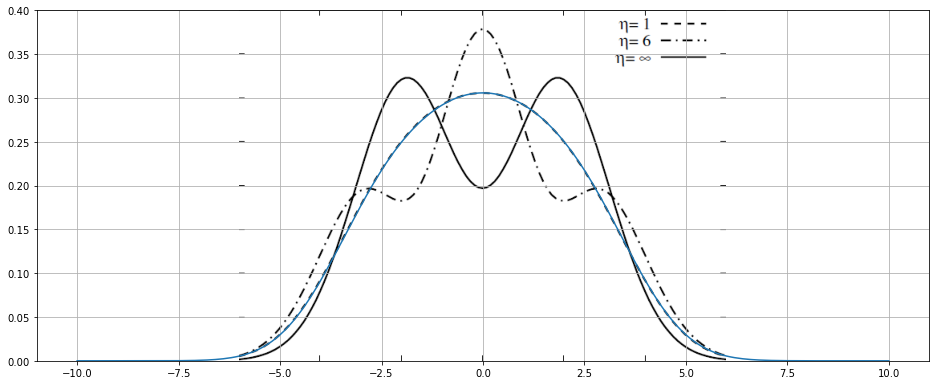

In [92]:
obd = do.eval_one_body_density(system, nparticles, C0)
do.plot_overlap_one_body_density(system, obd)


(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2)
(2, 2

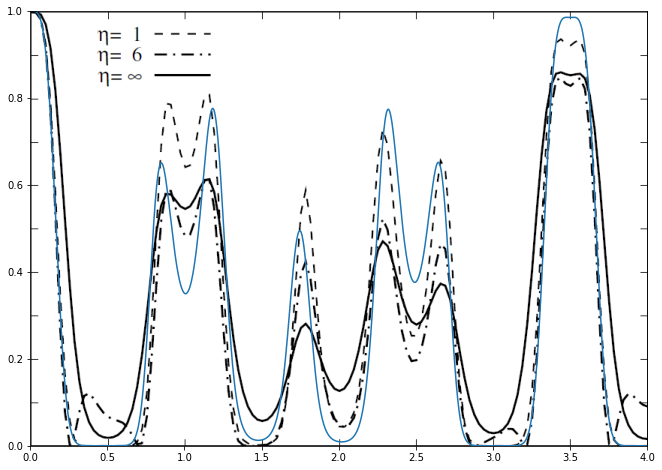

In [94]:
reload(do)
dt = 1e-3
t_max = 4*2*np.pi/omega
do.solve_TDHF(system, dt, t_max, C0, omega, epsilon0, nparticles)